# Customer Booking Prediction from Expedia Clickstream Data

Hongpeng Jin &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
469-543-7960 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
hopenjin@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
linkedin.com/in/hongpeng-jin/ <br />

GitHub: https://github.com/hopenjin/DataProject/blob/master/Hongpeng%20Jin_Project_Customer%20Booking%20Prediction%20from%20Expedia%20Clickstream%20Data.ipynb

This project is to analyst the personal data and behavioral data of customer, and to build a good model to predict a customer would book or not based on his or her data. <br /> 
The skills we used contains missing data processing, PCA, Logistic Regression, Support Vector Machine, Xgboost, and some visualization. <br /> 
So, let's start!

In [1]:
import warnings
warnings.filterwarnings("ignore")

First, we need to load data and show some data to know what it looks like.

In [2]:
# load dataset
import numpy as np
import pandas as pd

data=pd.read_csv("C:/Users/hopen/Desktop/Data-Analytics/expedia.csv")

Here we use some easy way, such as seaborn, to show the relationships between the personal data.

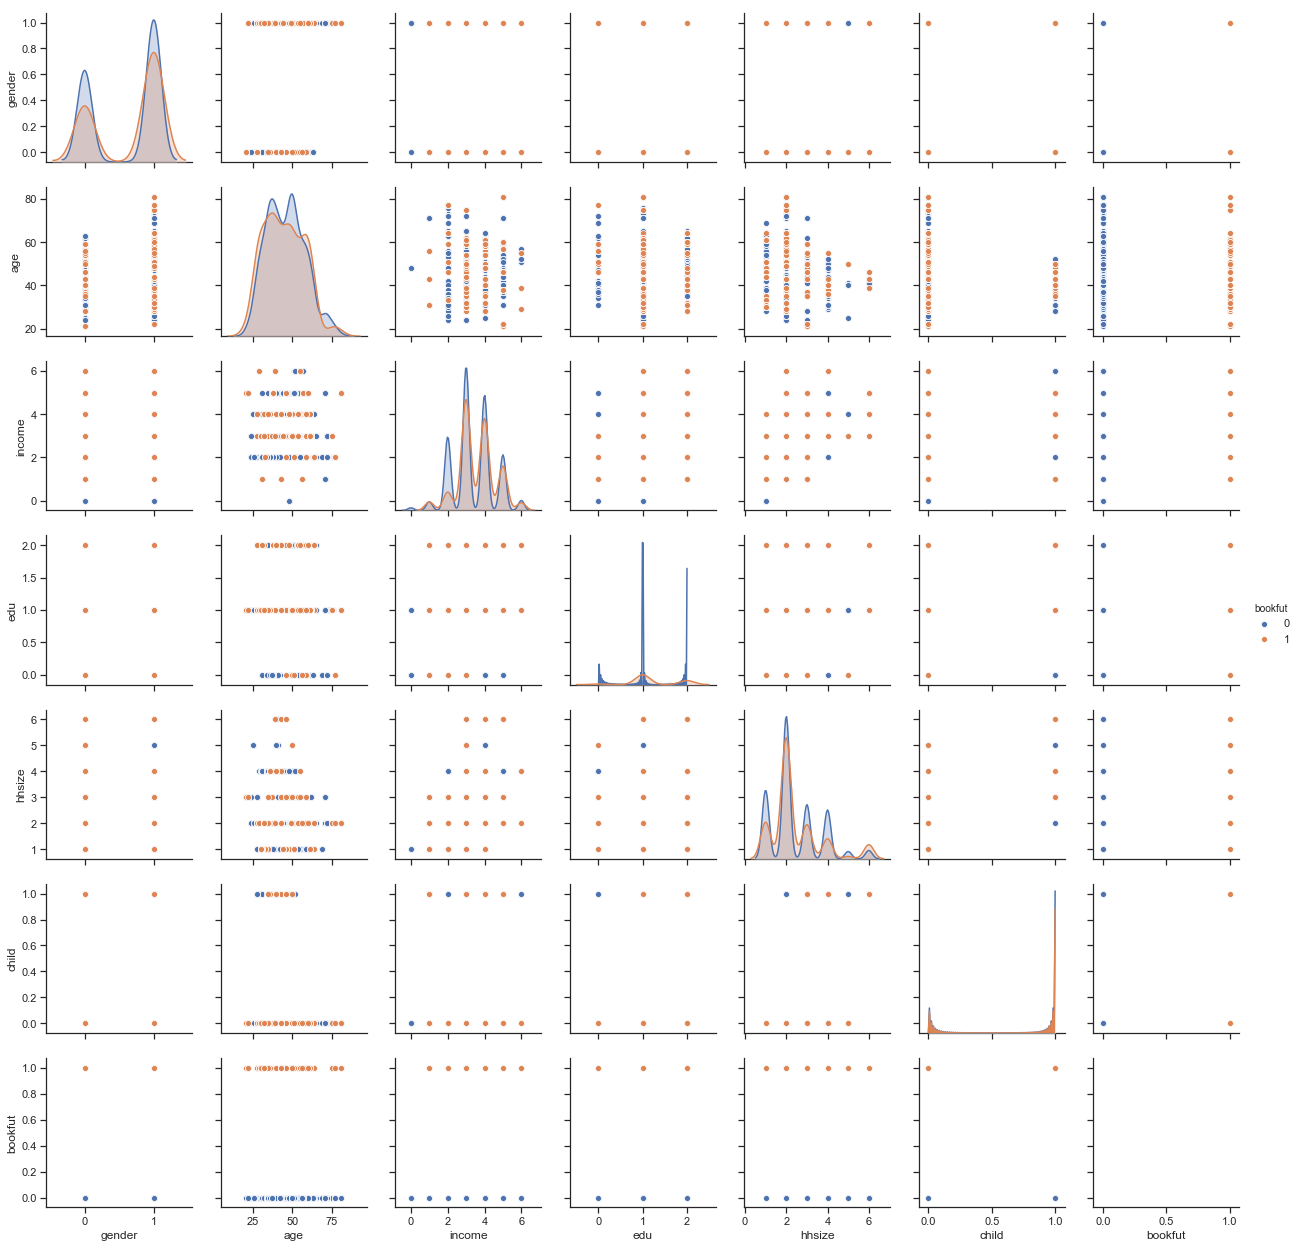

In [4]:
import seaborn as sns
sns.set(style="ticks")

df = data[['gender','age','income','edu','hhsize','child','bookfut']]
sns.pairplot(df, hue="bookfut")

It's looks no big difference between the user is going to book and the other. Let's the others.

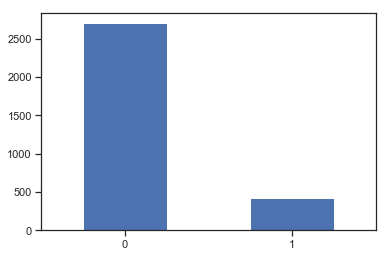

In [5]:
data.bookfut.value_counts().plot(kind="bar", rot=0)

Is this too much imbalanced? I suppose I should resample the dataset using SMOTE. However, after trying, the score didn't go up, so maybe it is fine.

In [6]:
data.head()

,gender,age,income,edu,hhsize,child,booklh,sesslh,minutelh,hpsesslh,...,SErate,bookgc,hitgc,basketgc,minutegc,SEgc,path,hitshc,minutshc,bookfut
0,1.0,28.0,3.0,1.0,2.0,NaN,NaN,4.0,22.5,10.5,...,1.0,1.0,155.0,5.0,46.0,1.0,NaN,0.49,0.39,0
1,0.0,28.0,4.0,NaN,2.0,0.0,0.0,NaN,0.0,0.0,...,NaN,1.0,10.0,2.0,14.5,0.0,NaN,0.40,0.44,0
2,0.0,41.0,NaN,1.0,3.0,0.0,0.0,NaN,23.8,9.5,...,NaN,0.0,9.0,1.0,6.0,1.0,NaN,1.00,1.00,0
3,1.0,50.0,4.0,1.0,2.0,0.0,1.0,3.0,49.2,35.3,...,NaN,0.0,22.0,1.0,35.0,1.0,NaN,NaN,1.00,0
4,1.0,31.0,5.0,2.0,2.0,0.0,0.0,6.0,NaN,18.0,...,NaN,0.0,5.0,NaN,3.0,1.0,0.0,0.80,0.76,0


After reading some row of this data, we could find there are many 'NaN' in many columns, so we need to deal with them first since some models couldn't be trained using this data.

In [7]:
data.isna().sum()

gender       319
age          311
income       318
edu          315
hhsize       295
child        304
booklh       311
sesslh       327
minutelh     339
hpsesslh     309
mpsesslh     322
booklc       302
httlc        297
minutelc     320
weekend      268
bookgh       313
sespsite     306
sessgh       329
minutegh     305
hpsessgh     356
mpsessgh     308
awareset     326
basket       321
single       282
booksh       339
hitsh        299
sessh        319
minutesh     273
entrate      308
peakrate     325
exitrate     310
SErate      1594
bookgc       332
hitgc        341
basketgc     333
minutegc     293
SEgc         310
path        1831
hitshc       310
minutshc     301
bookfut        0
dtype: int64

OK, so we find almost all the columns have 'NaN' value, so this is a big problem for us. <br /> 
We could see the result, it shows that most of them have around 300 missing value, but the number of missing value in "SErate" and "path" is huge!<br /> 
We could use the mean or mode of these columns to fill their missing value, but it might be a problem to fill the column named "SErate" and "path" since they miss too many, almost half of the total number. If we still use this way, it might cause some bias. <br /> 
Therefore, my plan is to fill the columns with small number of 'NaN', and then use these columns to predict the columns with small number.<br />

## Miss Data Processing ---- using Random Forest

We have talked the way to deal with missing value. Here, we need talk more details about our plan. <br />
First, divide the column "SErate", the column "path" and the targe column from data, and name x_data.<br />
Second, fill use the mode of each column in x_data to fill its missing value, so we could get a x_data without 'NaN' value.<br />
Third, concat the x_data with the column "SErate" and the column "path" separately, and then cut the data into training data and testing data depended the row has 'NaN' or not. In other words, we use the row with value of "SErate" or "path" as training data to predict the row without the value of "SErate" or "path".<br />
Fourthly, we use the training data to train a Random Forest model, and predict the value of "SErate" or "path" in testing.<br /> 
Next, use the prediction to fill the column "SErate" and the "path", then concat training data and testing data. Here, be careful with the sort of the data. If concat directly, the index would change which would cause the problem that x_data would not match the targe column.<br />
Final, we get two x_data, one with the column "SErate" and the other with "path", so what we do here is divide the column "SErate" from the fist x_data and combine it with the x_data with the column "path".<br />
So far, we get x_data without 'NaN', this problem is solved! Nice!<br />

In [8]:
# data divide into x_data, data['SErate'], data['path'], y_data
x_data = data.loc[:,(data.columns != 'bookfut') & (data.columns !='SErate') & (data.columns != 'path')]
y_data = data['bookfut']
SErate_data = data['SErate']
path_data = data['path']
columns_name = x_data.columns.values

In [9]:
# use 'mean value' to fill the rest of columns expect data['SErate'] and data['path']
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values = 'NaN' , strategy = 'most_frequent',axis=0)                        
nan_model = imp.fit(x_data)
x_data = nan_model.fit_transform(x_data)

# change back the array to dataframe format
x_data = pd.DataFrame(x_data,columns=columns_name)

C:\Users\hopen\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
# concat the filled columns with data['SErate'], here to fill data['SErate'] first
data_SErate = pd.concat([x_data, SErate_data],axis=1)
data_path = pd.concat([x_data, path_data],axis=1)

# Separate into train and test data set
train_SErate = data_SErate.dropna()
x_train_SErate = train_SErate.loc[:,train_SErate.columns !='SErate']
y_train_SErate = train_SErate['SErate']
test_SErate = data_SErate[lambda test_SErate: test_SErate['SErate'].isna()]
x_test_SErate = test_SErate.loc[:,test_SErate.columns !='SErate']
y_pred_SErate = test_SErate['SErate']

train_path = data_path.dropna()
x_train_path = train_path.loc[:,train_path.columns !='path']
y_train_path = train_path['path']
test_path = data_path[lambda test_path: test_path['path'].isna()]
x_test_path = test_path.loc[:,test_path.columns !='path']
y_pred_path = test_path['path']

In [11]:
# predict the missing value in data['path'] using Random Forest model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# clf = SVC()
clf = RandomForestClassifier()    # Random Forest is better than SVM

lab_enc = LabelEncoder()
y_train_SErate_encoded = lab_enc.fit_transform(y_train_SErate)
y_train_path_encoded = lab_enc.fit_transform(y_train_path)

clf.fit(x_train_SErate, y_train_SErate_encoded)
y_pred_SErate=clf.predict(x_test_SErate) # predict the test data
clf.fit(x_train_path, y_train_path_encoded)
y_pred_path=clf.predict(x_test_path) # predict the test data

In [12]:
# concat the filled data['SErate'] and data['path'] to x_train and x_test 
x_train_SErate = pd.concat([x_train_SErate, y_train_SErate],axis=1)
x_test_SErate['SErate'] = y_pred_SErate
x_train_path = pd.concat([x_train_path, y_train_path],axis=1)
x_test_path['path'] = y_pred_path

# concat the two divided datasets (x_train and x-test) into one dataset and sort by old way
x_data_SErate = pd.concat([x_train_SErate, x_test_SErate],axis=0).reindex(x_data.index)
x_data_path = pd.concat([x_train_path, x_test_path],axis=0).reindex(x_data.index)

In [13]:
# after fill data['SErate_data'] and data['path_data'], combine back to x_data
SErate_data = x_data_SErate['SErate']
x_data = x_data_path
x_data = pd.concat([x_data, SErate_data],axis=1)

In [14]:
# check the x_data is filled or not 
x_data.isna().sum()

gender      0
age         0
income      0
edu         0
hhsize      0
child       0
booklh      0
sesslh      0
minutelh    0
hpsesslh    0
mpsesslh    0
booklc      0
httlc       0
minutelc    0
weekend     0
bookgh      0
sespsite    0
sessgh      0
minutegh    0
hpsessgh    0
mpsessgh    0
awareset    0
basket      0
single      0
booksh      0
hitsh       0
sessh       0
minutesh    0
entrate     0
peakrate    0
exitrate    0
bookgc      0
hitgc       0
basketgc    0
minutegc    0
SEgc        0
hitshc      0
minutshc    0
path        0
SErate      0
dtype: int64

Zero missing value. Done!<br />

After filling missing value, we also need to scale the data since the data ranges in each column are different with others, which would cause bias. Therefore, we need to scale them.

In [15]:
#Scaling x_data
from sklearn.preprocessing import scale
x_data = scale(x_data)

Here, considering there might be some columns that correlate with others, we try to do Principal component analysis to reduce these influence.

In [16]:
# dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(0.95)
x_data_pca = pca.fit_transform(x_data)
print(pca.explained_variance_ratio_)   

[0.12343461 0.11406248 0.07583041 0.06487466 0.04707799 0.0444982
 0.0388389  0.03573896 0.03180173 0.02988792 0.02875949 0.02727817
 0.02352303 0.02249683 0.02148362 0.02014948 0.01888882 0.01870817
 0.01797641 0.01684941 0.01656726 0.01538752 0.01419055 0.01193811
 0.01149745 0.01099439 0.01069223 0.01002865 0.00962021 0.00932443
 0.00819034]


It looks good!<br />

Now, let start to train our models. I choose Logistic Regression, Support Vector Machine, Gradient Boosting and Xgboost. Before that, don't forget separate the data into training data and testing data!

In [17]:
#Separate into train and test data set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x_data,y_data,test_size=0.3,random_state=0)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

# Add the models to the list that you want to view on the ROC plot
models = [
           {'label': 'Logistic Regression',   'model': LogisticRegression(),},
           {'label': 'SVC',                   'model': svm.SVC(probability=True),},
           {'label': 'Gradient Boosting',     'model': GradientBoostingClassifier(),},
           {'label': 'XGBClassifier',         'model': XGBClassifier(),}
]

Test accuracy is 0.8665955176093917
Confusion matrix:
[[801  26]
 [ 99  11]]
Normalized Confusion matrix:
[[0.96856106 0.03143894]
 [0.9        0.1       ]]
Test accuracy is 0.9124866595517609
Confusion matrix:
[[824   3]
 [ 79  31]]
Normalized Confusion matrix:
[[0.99637243 0.00362757]
 [0.71818182 0.28181818]]
Test accuracy is 0.927427961579509
Confusion matrix:
[[820   7]
 [ 61  49]]
Normalized Confusion matrix:
[[0.99153567 0.00846433]
 [0.55454545 0.44545455]]
Test accuracy is 0.9178228388473852
Confusion matrix:
[[818   9]
 [ 68  42]]
Normalized Confusion matrix:
[[0.98911729 0.01088271]
 [0.61818182 0.38181818]]


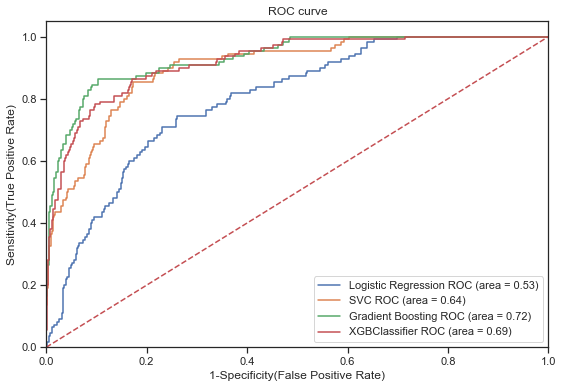

In [19]:
plt.figure(figsize=(9, 6))
# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
#  print out model evaluation
    print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred)))
    conf_mat =confusion_matrix(y_test,y_pred)
    print("Confusion matrix:\n%s" % conf_mat)
    conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    print("Normalized Confusion matrix:\n%s" % conf_mat_norm)
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()   # Display

So far, we finish training our models and get some info about their performance. Here, we could say the models using Gradient Boosting or Xgboost are pretty good. If we do more parameter tuning, they would get higher accuracy.